In [60]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
import torch

In [62]:
from torch.utils.data import Dataset, DataLoader

In [63]:
hsi_data= sio.loadmat('KSC.mat')['KSC']
labels = sio.loadmat('KSC_gt.mat')['KSC_gt']

In [64]:
[height,width,depth]=hsi_data.shape

In [65]:
def splitTrainTestSet(X, y, testRatio=0.10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

In [66]:
def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createPatches(X, y, windowSize=11, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train

In [67]:
import numpy as np
import scipy
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model

In [68]:
weight_of_size=10

In [69]:
X=hsi_data
y=labels

In [70]:
X,pca = applyPCA(X,30)

In [71]:
X.shape

(512, 614, 30)

In [72]:
XPatches, yPatches = createPatches(X, y, windowSize=15)

In [73]:
XPatches.shape

(5211, 15, 15, 30)

In [74]:
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, testRatio=0.2)

In [75]:
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[3],X_train.shape[1],X_train.shape[1]))

In [76]:
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[3],X_test.shape[1],X_test.shape[1]))

In [77]:
X_train.shape

(4168, 30, 15, 15)

In [78]:
X_train.shape

(4168, 30, 15, 15)

In [79]:
y_train

array([ 0., 12.,  3., ...,  0.,  5.,  9.])

In [80]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).int()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [81]:
data_train = MyDataset(X_train, y_train)

In [82]:
input_shape= X_train[0].shape
print(input_shape)

(30, 15, 15)


In [83]:
data_train.__getitem__(0)[0].shape

torch.Size([30, 15, 15])

In [84]:
n_epochs = 8
batch_size_train = 16
batch_size_test = 10
learning_rate = 0.01
momentum = 0.5
log_interval = 100
first_HL = 8

In [85]:
import torch
import torchvision

## Call the Dataset Class 
#data_train = torchvision.datasets.IndianPines('./data',download=True,PATCH_LENGTH=2)

## Check the shapes
print(data_train.__getitem__(0)[0].shape)
print(data_train.__len__())


## Wrap it around a Torch Dataloader
train_loader = torch.utils.data.DataLoader(data_train,batch_size=16,shuffle=True, num_workers=2)

torch.Size([30, 15, 15])
4168


In [86]:
len(data_train)

4168

In [87]:
data_test=MyDataset(X_test, y_test)

In [88]:
import torch
import torchvision

## Call the Dataset Class 
#data_test = torchvision.datasets.IndianPines('./data',download=True,PATCH_LENGTH=2)

## Check the shapes
print(data_test.__getitem__(0)[0].shape)
print(data_test.__len__())

torch.Size([30, 15, 15])
1043


In [89]:
test_loader = torch.utils.data.DataLoader(data_test,batch_size=10,shuffle=False, num_workers=2)

torch.Size([10, 30, 15, 15])


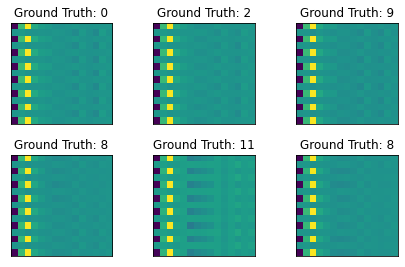

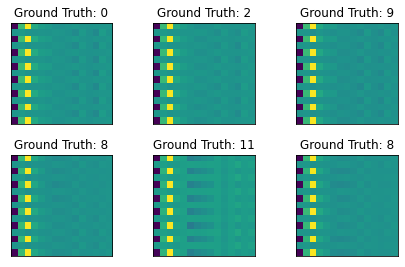

In [90]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data.shape)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [91]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import random

In [111]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 16
learning_rate = 0.001

torch.manual_seed(0)
random.seed(0)

In [112]:
Half_width =60
layer_width = 20

In [113]:
class SpinalCNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(SpinalCNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=30, out_channels=15, kernel_size=3, padding=1),
            nn.BatchNorm2d(15),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=15, out_channels=30, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=30, out_channels=60, kernel_size=3, padding=1),
            nn.BatchNorm2d(60),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=60, out_channels=60, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=60, out_channels=120, kernel_size=3, padding=1),
            nn.BatchNorm2d(120),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=120, out_channels=120, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p=0.1), nn.Linear(Half_width, layer_width),
            nn.ReLU(inplace=True),
            )
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p=0.1), nn.Linear(Half_width + layer_width, layer_width),
            nn.ReLU(inplace=True),
            )
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p=0.1), nn.Linear(Half_width + layer_width, layer_width),
            nn.ReLU(inplace=True),
            )
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p=0.1), nn.Linear(Half_width + layer_width, layer_width),
            nn.ReLU(inplace=True),
            )
        self.fc_out = nn.Sequential(
            nn.Dropout(p=0.1), nn.Linear(layer_width*4, 16)            
            )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        x1 = self.fc_spinal_layer1(x[:, 0:Half_width])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,Half_width:2*Half_width], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:Half_width], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,Half_width:2*Half_width], x3], dim=1))
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        x = self.fc_out(x)

        return x

In [114]:
from tensorflow.keras.optimizers import Adam
model = SpinalCNN().to(device)
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

SpinalCNN(
  (conv_layer): Sequential(
    (0): Conv2d(30, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(15, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_st

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [115]:
from torchvision import models
from torchsummary import summary
model = SpinalCNN().to(device)
summary(model, (30, 15, 15))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 15, 15]           4,065
       BatchNorm2d-2           [-1, 15, 15, 15]              30
              ReLU-3           [-1, 15, 15, 15]               0
            Conv2d-4           [-1, 30, 15, 15]           4,080
              ReLU-5           [-1, 30, 15, 15]               0
         MaxPool2d-6             [-1, 30, 7, 7]               0
            Conv2d-7             [-1, 60, 7, 7]          16,260
       BatchNorm2d-8             [-1, 60, 7, 7]             120
              ReLU-9             [-1, 60, 7, 7]               0
           Conv2d-10             [-1, 60, 7, 7]          32,460
             ReLU-11             [-1, 60, 7, 7]               0
        MaxPool2d-12             [-1, 60, 3, 3]               0
        Dropout2d-13             [-1, 60, 3, 3]               0
           Conv2d-14            [-1, 12

In [116]:
model = SpinalCNN().to(device)



# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
       
        #print(images.shape)
        # Forward pass
        outputs = model(images)
        labels = torch.tensor(labels, dtype=torch.long, device=device)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 500 == 0:
          print("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            

    # Decay learning rate
    if (epoch) == 1 or epoch>20:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
        
        # Test the model
    model.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      predicted_numpy=[]
      for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_numpy.append(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
      print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
                
      model.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy of the model on the test images: 65.29242569511025 %
Accuracy of the model on the test images: 74.97603068072867 %
Accuracy of the model on the test images: 85.0431447746884 %
Accuracy of the model on the test images: 74.59252157238734 %
Accuracy of the model on the test images: 88.68648130393098 %
Accuracy of the model on the test images: 87.91946308724832 %
Accuracy of the model on the test images: 90.12464046021093 %
Accuracy of the model on the test images: 88.20709491850431 %
Accuracy of the model on the test images: 89.83700862895493 %
Accuracy of the model on the test images: 89.74113135186961 %
Accuracy of the model on the test images: 91.46692233940556 %
Accuracy of the model on the test images: 89.26174496644295 %
Accuracy of the model on the test images: 93.28859060402685 %
Accuracy of the model on the test images: 93.7679769894535 %
Accuracy of the model on the test images: 95.11025886864813 %
Accuracy of the model on the test images: 95.39789069990412 %


In [117]:
len(predicted_numpy)

105

In [118]:
predicted_numpy = np.concatenate(predicted_numpy)

In [119]:
predicted_numpy.shape

(1043,)

In [120]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
y_true = y_test
y_pred = predicted_numpy
print(confusion_matrix(y_true, y_pred), end='\n')

[[150   0   0   1   1   0   0   0   0   0   0   0   0]
 [  0  42   0   4   2   1   0   0   0   0   0   0   0]
 [  0   0  48   2   1   0   0   0   0   0   0   0   0]
 [  1   0   7  42   0   0   0   0   0   0   0   0   0]
 [  0   0   6   1  25   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0  45   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  21   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0  80   5   0   0   0   0]
 [  0   0   0   0   0   0   0   8  96   0   0   0   0]
 [  0   0   0   0   0   0   0   2   0  78   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0  84   0   0]
 [  0   0   1   0   1   0   0   0   0   0   0  99   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0 185]]


AxesSubplot(0.125,0.125;0.62x0.755)


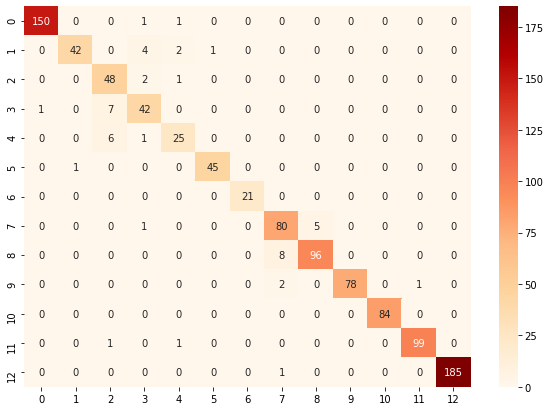

In [135]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
y_true = y_test
y_pred = predicted_numpy
plt.figure(figsize = (10,7))
print(sn.heatmap(confusion_matrix(y_true, y_pred),annot=True,cmap="OrRd",fmt='d'))
plt.savefig('KSC_pca_Confusion Matrix')

In [122]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_true, y_pred, labels=None, weights=None, sample_weight=None))

0.9487756139835698


In [123]:
from sklearn.metrics import classification_report

In [124]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
y_true = y_test
y_pred = predicted_numpy
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9', 'class 10', 'class 11', 'class 12']
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

     class 0     0.9934    0.9868    0.9901       152
     class 1     0.9767    0.8571    0.9130        49
     class 2     0.7742    0.9412    0.8496        51
     class 3     0.8235    0.8400    0.8317        50
     class 4     0.8333    0.7812    0.8065        32
     class 5     0.9783    0.9783    0.9783        46
     class 6     1.0000    1.0000    1.0000        21
     class 7     0.8791    0.9302    0.9040        86
     class 8     0.9505    0.9231    0.9366       104
     class 9     1.0000    0.9630    0.9811        81
    class 10     1.0000    1.0000    1.0000        84
    class 11     0.9900    0.9802    0.9851       101
    class 12     1.0000    0.9946    0.9973       186

    accuracy                         0.9540      1043
   macro avg     0.9384    0.9366    0.9364      1043
weighted avg     0.9565    0.9540    0.9545      1043



In [125]:
f = sio.loadmat('KSC.mat')['KSC']
g = sio.loadmat('KSC_gt.mat')['KSC_gt']

In [126]:
F,pca = applyPCA(f,30)

In [127]:
FPatches, gPatches = createPatches(F,g, windowSize=15)

In [130]:
import itertools

In [131]:
def classified_pixels(FPatches,gPatches,g):
  FPatches=np.reshape(FPatches,(FPatches.shape[0],FPatches.shape[3],FPatches.shape[1],FPatches.shape[2]))
  data_test=MyDataset(FPatches, gPatches)
  test_loader = torch.utils.data.DataLoader(data_test,batch_size=10,shuffle=False, num_workers=2)
  with torch.no_grad():
    correct = 0
    total = 0
    predicted_numpy=[]
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      predicted_numpy.append(predicted.cpu().numpy())
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  classification_map=np.array(predicted_numpy)
  cm=[]
  for arr in classification_map:
    cm.append(arr.tolist())
  cm=list(itertools.chain.from_iterable(cm))
  classification_map=np.array(cm)

  height=g.shape[0]
  width=g.shape[1]
  outputs = np.zeros((height,width))
  k=0
  for i in range(height):
    for j in range(width):
       target = g[i][j]
       if target == 0 :
         continue
       else :
        outputs[i][j]=classification_map[k]
       k=k+1
  return classification_map,outputs

In [132]:
cma,out=classified_pixels(FPatches,gPatches,g)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


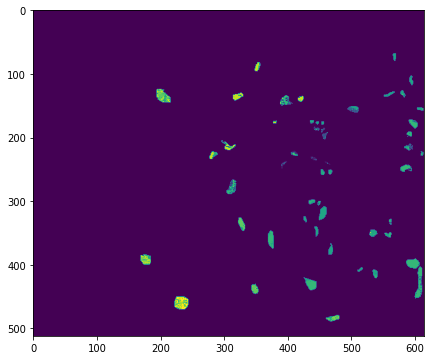

In [133]:
plt.figure(figsize=(7,7))
a=plt.imshow(out)
plt.savefig('KSC_pca_cmap')

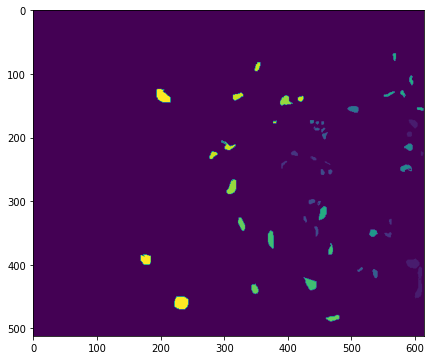

In [134]:
plt.figure(figsize=(7,7))
plt.imshow(g)
plt.savefig('KSC_pca_gt')